In [1]:
%matplotlib inline

import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from utils import setup_output_dirs

/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# ============================================= #
# Load data
# ============================================= #
# Domain
da_smap_domain = xr.open_dataset('/civil/hydro/ymao/smap_data/param/domain/smap.domain.global.nc')['mask']
# SMAP
ds_smap = xr.open_dataset('/civil/hydro/ymao/smap_data/tools/prepare_SMAP/output/data/soil_moisture.20150331_20171231.nc')
## GPM
#ds_prec = xr.open_dataset('/civil/hydro/ymao/smap_data/tools/prepare_GPM/output/L3_Final_global.12hour.36km/prec.20150101_20171231.nc')

# Output dir
output_dir = '/civil/hydro/ymao/smap_data/tools/data_quality_control/output'

ds_smap.load()
ds_smap.close()
#ds_prec.load()
#ds_prec.close()

In [3]:
# ============================================= #
# Setup subdir
# ============================================= #
output_plot_dir = setup_output_dirs(
    output_dir, mkdirs=['plot'])['plot']

# SMAP data quality

In [4]:
# ============================================= #
# Calculate the version of da_smap with
# internally "recommended quality" data points only
# ============================================= #
da_smap_recom_qual = ds_smap['soil_moisture'].where(
    ds_smap['retrieval_qual_flag']==0)
# Set up dict_da_smap
dict_da_smap = {'raw': ds_smap['soil_moisture'],
                'recom_qual': da_smap_recom_qual}

In [5]:
# ============================================= #
# Average SMAP sampling frequency
# ============================================= #
# --- Count the number of SMAP observations for each pixel --- #
dict_n_smap_obs = {}  # {smap_key: n_smap_obs}
dict_n_smap_obs_season = {}  # {smap_key: season: n_smap_obs}
dict_n_smap_total_season = {}  # total number of 12-hour timestamps
                               # {smap_key: season: n_smap_obs}
for key, da_smap in dict_da_smap.items():
    # --- Total sampling points --- #
    n_smap_obs = np.count_nonzero(
        ~np.isnan(da_smap),
        axis=0)
    dict_n_smap_obs[key] = n_smap_obs

    # --- Seasonal sampling points --- #
    dict_n_smap_obs_season[key] = {}
    dict_n_smap_total_season[key] = {}
    for season, item in da_smap.groupby('time.season'):
        dict_n_smap_total_season[key][season] = len(item['time'])
        n_smap_obs = np.count_nonzero(
            ~np.isnan(item),
            axis=0)
        dict_n_smap_obs_season[key][season] = n_smap_obs

/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


NameError: name 'add_gridlines' is not defined

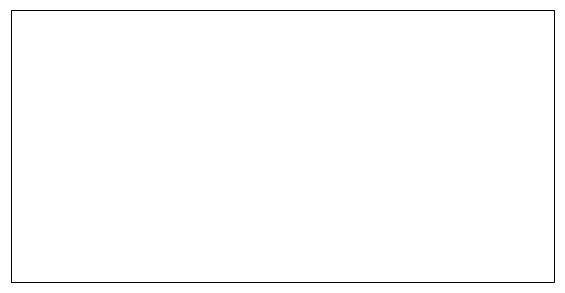

In [6]:
# --- Plot average sampling frequency (day-1) --- #
dict_da_smap_freq_mean = {}
for key in ['raw', 'recom_qual']:
    # --- Calculate average sampling frequency --- #
    n_smap_obs = dict_n_smap_obs[key]
    da_smap = dict_da_smap[key]
    smap_freq_mean = \
        n_smap_obs / len(da_smap['time']) * 2  # day-1
    da_smap_freq_mean = xr.DataArray(
        smap_freq_mean,
        coords=[da_smap['lat'], da_smap['lon']],
        dims=['lat', 'lon']).where(da_smap_domain==1)
    dict_da_smap_freq_mean[key] = da_smap_freq_mean
    
    # --- Plot map --- #
    fig = plt.figure(figsize=(12, 5))
    # Set projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = add_gridlines(ax, alpha=0)
    # Plot
    cs = da_smap_freq_mean.where(da_smap_domain==1).plot.pcolormesh(
        'lon', 'lat', ax=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='jet',
        vmin=0, vmax=1,
        transform=ccrs.PlateCarree())
    cbar = plt.colorbar(cs, extend='max')
    cbar.set_label('Sampling frequency (day-1)', fontsize=20)
    plt.title('Average SMAP sampling frequency, {} data'.format(key),
              fontsize=20)
    # Save fig
    fig.savefig(
        os.path.join(
            output_plot_dir,
            'smap_avg_sampling_freq.smap_{}.png'.format(key)),
        format='png', bbox_inches='tight', pad_inches=0)
    
    # --- Plot histogram of the average sampling frequency --- #
    smap_freq_allval = da_smap_freq_mean.values.flatten()
    smap_freq_allval = smap_freq_allval[~np.isnan(smap_freq_allval)]
    fig = plt.figure(figsize=(8, 6))
    plt.hist(smap_freq_allval, density=True)
    plt.xlabel('Average sampling frequency (day-1)', fontsize=20)
    plt.ylabel('PDF', fontsize=20)
    plt.title(('PDF of average sampling frequency\n'
               '({} data)').format(key), fontsize=20)
    # Save fig
    fig.savefig(
        os.path.join(
            output_plot_dir,
            'hist.smap_avg_sampling_freq.smap_{}.png'.format(key)),
        format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- Plot average sampling frequency - seasonal (day-1) --- #
for key in ['raw', 'recom_qual']:
    for season in dict_n_smap_obs_season['raw'].keys():
        # --- Calculate average sampling frequency --- #
        n_smap_obs = dict_n_smap_obs_season[key][season]
        smap_freq_mean = \
            n_smap_obs / \
            dict_n_smap_total_season[key][season] * 2  # day-1
        da_smap_freq_mean = xr.DataArray(
            smap_freq_mean,
            coords=[da_smap['lat'], da_smap['lon']],
            dims=['lat', 'lon']).where(da_smap_domain==1)

        # --- Plot map --- #
        fig = plt.figure(figsize=(12, 5))
        # Set projection
        ax = plt.axes(projection=ccrs.PlateCarree())
        gl = add_gridlines(ax, alpha=0)
        # Plot
        cs = da_smap_freq_mean.where(da_smap_domain==1).plot.pcolormesh(
            'lon', 'lat', ax=ax,
            add_colorbar=False,
            add_labels=False,
            cmap='jet',
            vmin=0, vmax=1,
            transform=ccrs.PlateCarree())
        cbar = plt.colorbar(cs, extend='max')
        cbar.set_label('Sampling frequency (day-1)', fontsize=20)
        plt.title(
            'Average SMAP sampling frequency for {}, {} data'.format(
                season, key),
            fontsize=20)
        # Save fig
        fig.savefig(
            os.path.join(
                output_plot_dir,
                'smap_avg_sampling_freq.{}.smap_{}.png'.format(
                    season, key)),
            format='png', bbox_inches='tight', pad_inches=0)

        # --- Plot histogram of the average sampling frequency --- #
        smap_freq_allval = da_smap_freq_mean.values.flatten()
        smap_freq_allval = smap_freq_allval[~np.isnan(smap_freq_allval)]
        fig = plt.figure(figsize=(8, 6))
        plt.hist(smap_freq_allval, density=True)
        plt.xlabel('Average sampling frequency (day-1)', fontsize=20)
        plt.ylabel('PDF', fontsize=20)
        plt.title(('PDF of average sampling frequency\n'
                   '({}, {} data)').format(season, key), fontsize=20)
        # Save fig
        fig.savefig(
            os.path.join(
                output_plot_dir,
                'hist.smap_avg_sampling_freq.{}.smap_{}.png'.format(
                    season, key)),
            format='png', bbox_inches='tight', pad_inches=0)

In [12]:
# ============================================= #
# Maximum SMAP data gap
# ============================================= #
# --- Calculate maximum SMAP data gap for each pixel --- #
dict_max_gap = {}
for key, da_smap in dict_da_smap.items():
    da_notnull_cumsum = \
        da_smap.notnull().astype(int).cumsum(dim='time')


In [ ]:
max_gap = \
    [da_smap[:, lat_ind, lon_ind].isnull().astype(int).to_series(
        ).groupby(
        da_notnull_cumsum[:, lat_ind, lon_ind].to_series()).sum().max()
     for lat_ind in range(len(da_smap['lat']))
     for lon_ind in range(len(da_smap['lon']))]

In [9]:
da_notnull_cumsum = da_smap.notnull().astype(int).cumsum(dim='time')

In [22]:
da_smap[:, 260, 760].isnull().astype(int).to_series().groupby(
    da_notnull_cumsum[:, 260, 760].to_series()).sum().max()

15

In [13]:
# ============================================= #
# Other ways to measure uniformness of SMAP data gaps
# ============================================= #
# Seasonality

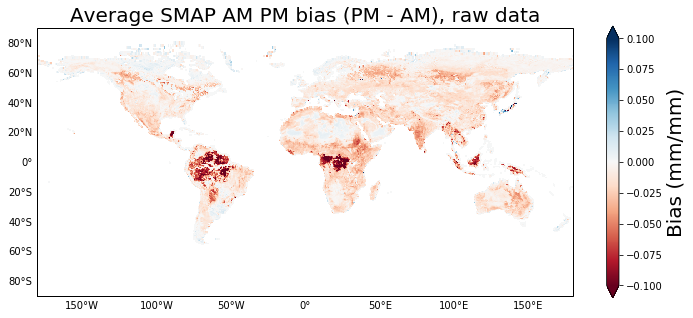

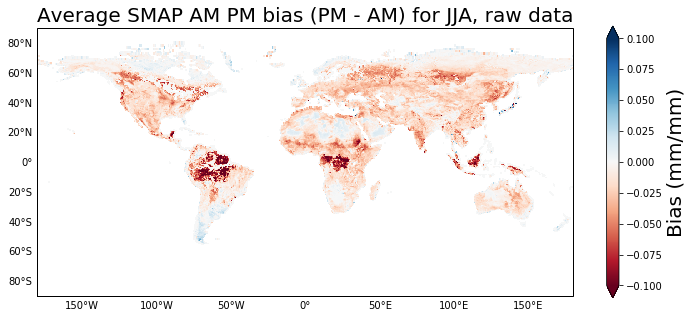

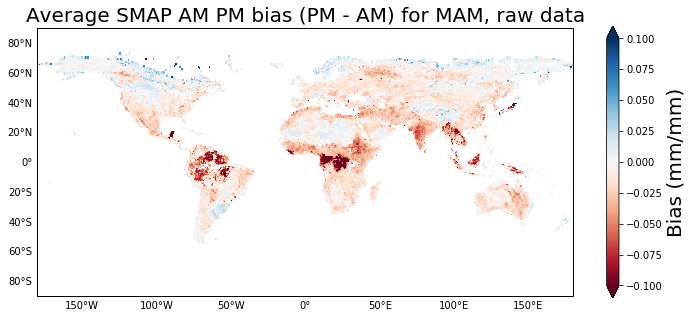

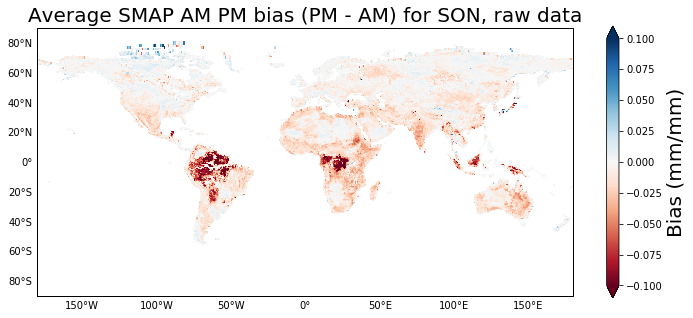

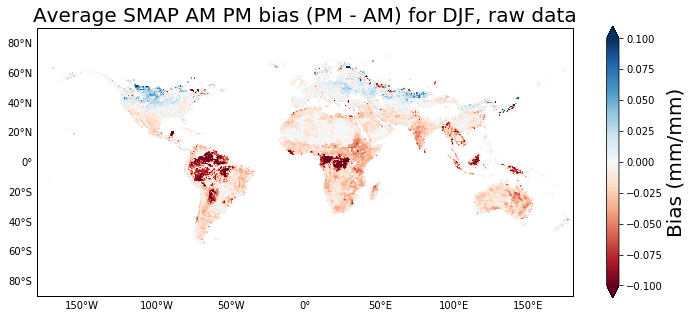

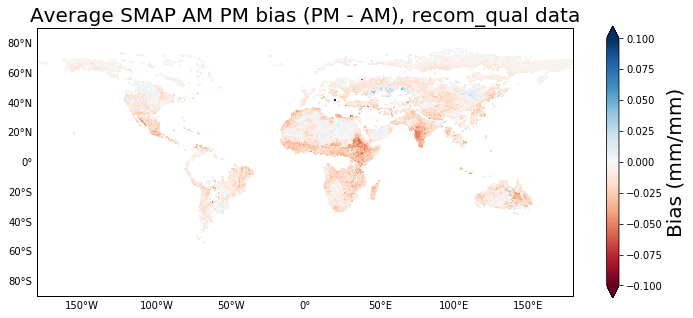

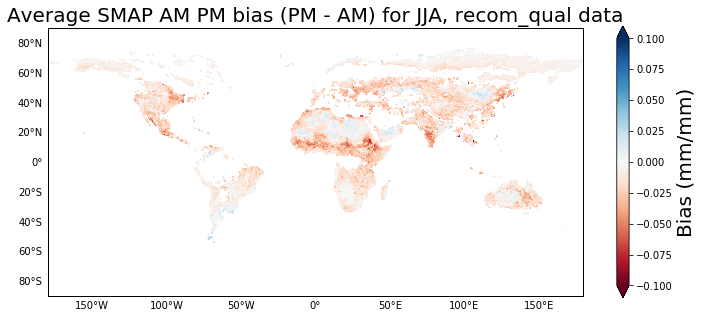

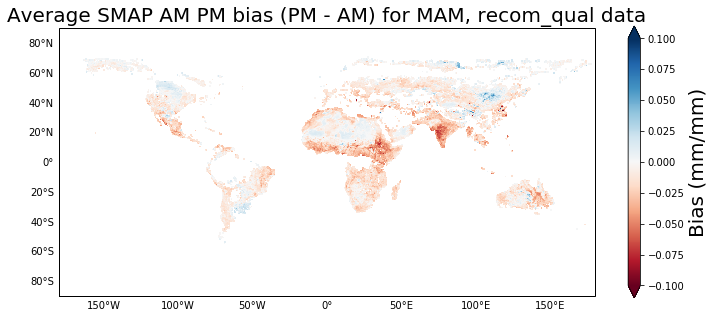

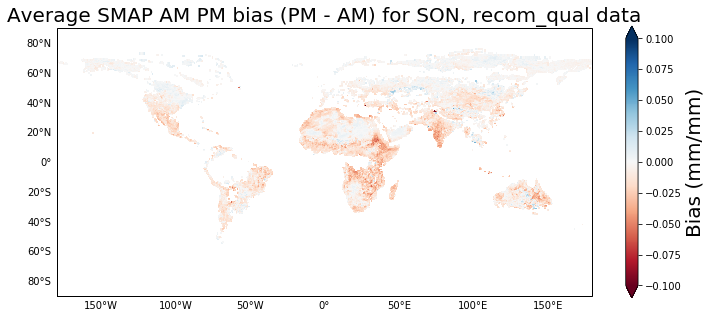

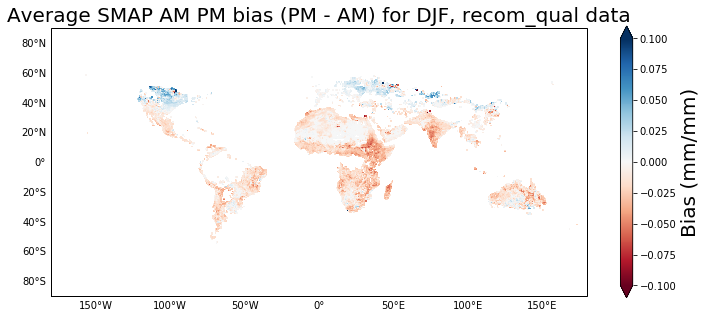

In [22]:
# ============================================= #
# Systematic difference between AM and PM orbits
# ============================================= #
for key, da_smap in dict_da_smap.items():
    # --- Separate AM and PM data --- #
    for hour, item in da_smap.groupby('time.hour'):
        if hour == 6:
            da_AM = item
        elif hour == 18:
            da_PM = item
            
    # --- Plot overall AM and PM bias --- #
    da_diff = da_PM.mean(dim='time') - da_AM.mean(dim='time')
    fig = plt.figure(figsize=(12, 5))
    # Set projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = add_gridlines(ax, alpha=0)
    # Plot
    if key == 'raw':
        da_mask = (da_smap_domain==1)
    elif key == 'recom_qual':
        da_mask = (dict_da_smap_freq_mean['recom_qual']>0)
    cs = da_diff.where(da_mask).plot.pcolormesh(
        'lon', 'lat', ax=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='RdBu',
        vmin=-0.1, vmax=0.1,
        transform=ccrs.PlateCarree())
    cbar = plt.colorbar(cs, extend='both')
    cbar.set_label('Bias (mm/mm)', fontsize=20)
    plt.title('Average SMAP AM PM bias (PM - AM), {} data'.format(key),
              fontsize=20)
    # Save fig
    fig.savefig(
        os.path.join(
            output_plot_dir,
            'smap_avg_AM_PM_bias.smap_{}.png'.format(key)),
        format='png', bbox_inches='tight', pad_inches=0)
    
    # --- Plot seasonal AM and PM bias --- #
    dict_da_AM_season = {}
    dict_da_PM_season = {}
    for season, item in da_AM.groupby('time.season'):
        dict_da_AM_season[season] = item
    for season, item in da_PM.groupby('time.season'):
        dict_da_PM_season[season] = item
    for season in dict_da_AM_season.keys():
        da_AM_season = dict_da_AM_season[season]
        da_PM_season = dict_da_PM_season[season]
        da_diff = da_PM_season.mean(dim='time') - \
            da_AM_season.mean(dim='time')
        fig = plt.figure(figsize=(12, 5))
        # Set projection
        ax = plt.axes(projection=ccrs.PlateCarree())
        gl = add_gridlines(ax, alpha=0)
        # Plot
        if key == 'raw':
            da_mask = (da_smap_domain==1)
        elif key == 'recom_qual':
            da_mask = (dict_da_smap_freq_mean['recom_qual']>0)
        cs = da_diff.where(da_mask).plot.pcolormesh(
            'lon', 'lat', ax=ax,
            add_colorbar=False,
            add_labels=False,
            cmap='RdBu',
            vmin=-0.1, vmax=0.1,
            transform=ccrs.PlateCarree())
        cbar = plt.colorbar(cs, extend='both')
        cbar.set_label('Bias (mm/mm)', fontsize=20)
        plt.title(
            'Average SMAP AM PM bias (PM - AM) for {}, {} data'.format(
                season, key),
            fontsize=20)
        # Save fig
        fig.savefig(
            os.path.join(
                output_plot_dir,
                'smap_avg_AM_PM_bias.{}.smap_{}.png'.format(
                    season, key)),
            format='png', bbox_inches='tight', pad_inches=0)

In [20]:
for season, item in da_PM.groupby('time.season'):
    print(season)

DJF
JJA
MAM
SON


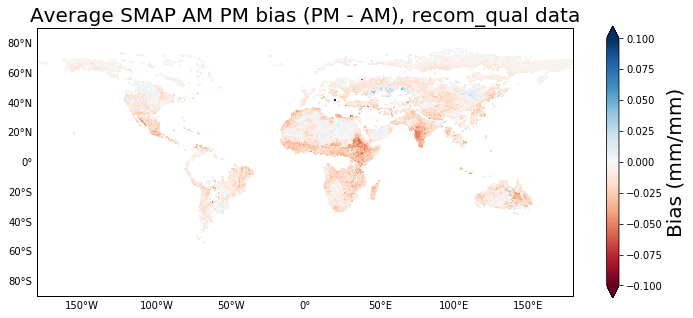

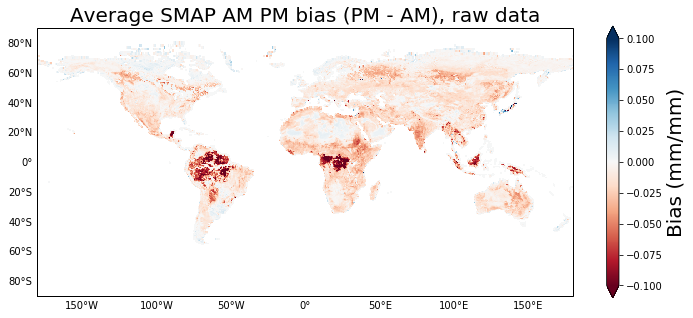

# Functions

In [8]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [9]:
def add_gridlines(axis,
                  xlocs=[-150, -100, -50, 0,
                         50, 100, 150],
                  ylocs=[-80, -60, -40, -20, 0, 20, 40, 60, 80],
                  alpha=1):
    gl = axis.gridlines(draw_labels=True, xlocs=xlocs, ylocs=ylocs,
                        alpha=alpha)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return gl